<a href="https://colab.research.google.com/github/tywong/tensorflow-learning/blob/master/TensorFlow_Tutorial_Text_classification_with_an_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification with an RNN

**Important: set your runtime to GPU**

## Install Packages

In [1]:
from __future__ import absolute_import, division, print_function

!pip install -q tensorflow-gpu==2.0.0-alpha0
import tensorflow_datasets as tfds
import tensorflow as tf

    100% |████████████████████████████████| 332.1MB 71kB/s 
    100% |████████████████████████████████| 3.0MB 9.0MB/s 
    100% |████████████████████████████████| 61kB 22.9MB/s 
    100% |████████████████████████████████| 419kB 13.5MB/s 


## Load Dataset - IMDB

Reference: https://www.tensorflow.org/datasets/datasets

In [3]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, 
                          as_supervised=True);
train_dataset, test_dataset = dataset['train'], dataset['test']

W0324 08:25:28.809935 140310727821184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_datasets/core/file_format_adapter.py:292: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [4]:
for k, v in dataset.items():
  print(k, v)

test <_OptionsDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>
train <_OptionsDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>


In [5]:
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=0.0.1,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing.',
    urls=['http://ai.stanford.edu/~amaas/data/sentiment/'],
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>)
    },
    total_num_examples=50000,
    splits={
        'test': <tfds.core.SplitInfo num_examples=25000>,
        'train': <tfds.core.SplitInfo num_examples=25000>
    },
    supervised_keys=('text', 'label'),
    citation='"""
        @InProceedings{maas-EtAl:2011:ACL-HLT2011,
          author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, C

### Encoder

In [0]:
tokenizer = info.features['text'].encoder


In [7]:
## there are two methods: decode and encode

help(tokenizer)

Help on SubwordTextEncoder in module tensorflow_datasets.core.features.text.subword_text_encoder object:

class SubwordTextEncoder(tensorflow_datasets.core.features.text.text_encoder.TextEncoder)
 |  Invertible `TextEncoder` using word pieces with a byte-level fallback.
 |  
 |  Encoding is fully invertible because all out-of-vocab wordpieces are
 |  byte-encoded.
 |  
 |  The vocabulary is "trained" on a corpus and all wordpieces are stored in a
 |  vocabulary file. To generate a vocabulary from a corpus, use
 |  `tfds.features.text.SubwordTextEncoder.build_from_corpus`.
 |  
 |  Typical usage:
 |  
 |  ```
 |  # Build
 |  encoder = tfds.features.text.SubwordTextEncoder.build_from_corpus(
 |      corpus_generator, target_vocab_size=2**15)
 |  encoder.save_to_file(vocab_filename)
 |  
 |  # Load
 |  encoder = tfds.features.text.SubwordTextEncoder.load_from_file(vocab_filename)
 |  ids = encoder.encode("hello world")
 |  text = encoder.decode([1, 2, 3, 4])
 |  ```
 |  
 |  Method resolu

In [8]:
tokenizer.vocab_size

8185

### Encoder Example

In [9]:
sample_string = 'TensorFlow is cool.'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [6307, 2327, 4043, 4265, 9, 2724, 7975]
The original string: TensorFlow is cool.


In [10]:
for ts in tokenized_string:
  print ('"{}" ----> "{}"'.format(ts, tokenizer.decode([ts])))

"6307" ----> "Ten"
"2327" ----> "sor"
"4043" ----> "Fl"
"4265" ----> "ow "
"9" ----> "is "
"2724" ----> "cool"
"7975" ----> "."


In [11]:
print(tokenizer.encode('is'))
print(tokenizer.encode('is '))  ## the 3 chars encoded into one token
print(tokenizer.encode(' is'))  ## the same 3 chars encoded into two tokens

[203]
[9]
[7961, 203]


### Create batches

In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [0]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)

train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)

test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)

## Create Model

Using Bi-Directional LSTM

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

W0324 08:26:11.537313 140310727821184 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f9c79bf1cf8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0324 08:26:11.550425 140310727821184 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f9c23101a20>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


In [0]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [16]:
history = model.fit(train_dataset,
                   epochs=10,
                   validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 157s 401ms/step - loss: 0.5404 - accuracy: 0.7154 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 152s 389ms/step - loss: 0.3679 - accuracy: 0.8507 - val_loss: 0.4585 - val_accuracy: 0.8155
Epoch 3/10
391/391 [==============================] - 151s 387ms/step - loss: 0.3111 - accuracy: 0.8778 - val_loss: 0.4098 - val_accuracy: 0.8354
Epoch 4/10
391/391 [==============================] - 151s 387ms/step - loss: 0.2364 - accuracy: 0.9107 - val_loss: 0.4383 - val_accuracy: 0.8200
Epoch 5/10
391/391 [==============================] - 152s 390ms/step - loss: 0.2055 - accuracy: 0.9242 - val_loss: 0.4504 - val_accuracy: 0.8408
Epoch 6/10
391/391 [==============================] - 153s 391ms/step - loss: 0.1961 - accuracy: 0.9255 - val_loss: 0.5347 - val_accuracy: 0.8350
Epoch 7/10
391/391 [==============================] - 152s 388ms/step - loss: 0.1434 - accuracy: 0.9494 - val_loss: 

### Evaluating Model

In [17]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

    391/Unknown - 43s 110ms/step - loss: 0.5788 - accuracy: 0.7179Test Loss: 0.5788379979255559
Test Accuracy: 0.7178800106048584


### Problem of the model

The train data set contains padding. When one uses the this model for prediction, padding must be added to the input comment / data.

### Introducing padding to the input / data

In [0]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [0]:
def sample_predict(input_model, sentence, pad):
  tokenized_sample_pred_text = tokenizer.encode(sample_pred_text)
  
  if pad:
    tokenized_sample_pred_text = pad_to_size(tokenized_sample_pred_text, 64)
  
  predictions = input_model.predict(tf.expand_dims(tokenized_sample_pred_text, 0))

  return (predictions)

#### Without padding: expected to have a lower score

In [20]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(model, sample_pred_text, pad=False)
print (predictions)

[[0.7189649]]


#### With padding: expected to have a higher score

In [21]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(model, sample_pred_text, pad=True)
print (predictions)

[[0.74243754]]


The padding data gives a slightly higher tendency to 1.

### Evaluating the model with graphs

In [0]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

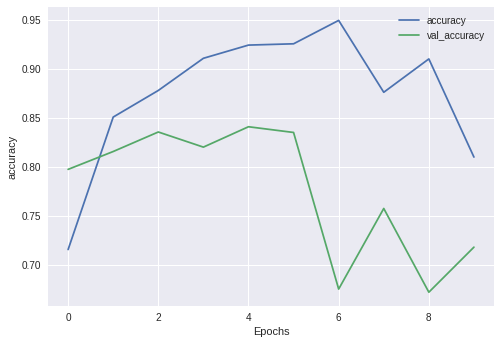

In [23]:
plot_graphs(history, 'accuracy')

So, this training is **over-fitting** the model.

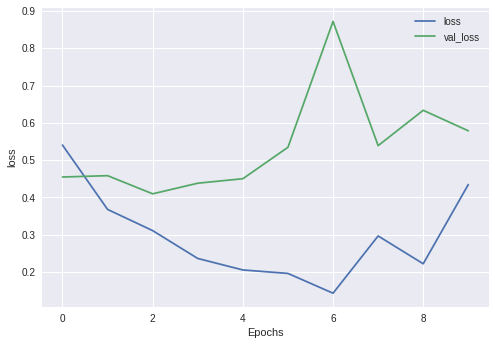

In [24]:
plot_graphs(history, 'loss')

## Advanced Model - More LSTM Layers

In [25]:
adv_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    
    ## modified original LSTM layers: return_sequence is True
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    
    ## new LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

W0324 09:01:00.229935 140310727821184 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f9c20041048>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0324 09:01:00.236398 140310727821184 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f9c017b72e8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0324 09:01:00.248099 140310727821184 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f9c017b7cf8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0324 09:01:00.252247 140310727821184 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f9c017cc0b8>: Note that this layer is not optimized for performance. Please use tf.keras.laye

In [0]:
adv_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [27]:
history = adv_model.fit(train_dataset, epochs=10, 
                    validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 284s 726ms/step - loss: 0.6042 - accuracy: 0.6694 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 280s 717ms/step - loss: 0.5059 - accuracy: 0.7588 - val_loss: 0.5814 - val_accuracy: 0.7536
Epoch 3/10
391/391 [==============================] - 281s 720ms/step - loss: 0.4668 - accuracy: 0.7902 - val_loss: 0.6636 - val_accuracy: 0.5586
Epoch 4/10
391/391 [==============================] - 281s 718ms/step - loss: 0.3336 - accuracy: 0.8657 - val_loss: 0.3689 - val_accuracy: 0.8495
Epoch 5/10
391/391 [==============================] - 281s 718ms/step - loss: 0.2430 - accuracy: 0.9079 - val_loss: 0.3602 - val_accuracy: 0.8502
Epoch 6/10
391/391 [==============================] - 280s 717ms/step - loss: 0.2012 - accuracy: 0.9267 - val_loss: 0.3752 - val_accuracy: 0.8599
Epoch 7/10
391/391 [==============================] - 282s 720ms/step - loss: 0.1606 - accuracy: 0.9446 - val_loss: 

### Model evaluation

In [31]:
test_loss, test_acc = adv_model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

    391/Unknown - 80s 204ms/step - loss: 0.4630 - accuracy: 0.8627Test Loss: 0.4630365310918035
Test Accuracy: 0.8627200126647949


### Prediction on a negative sentiment comment without padding

In [32]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(adv_model, sample_pred_text, pad=False)
print (predictions)

[[0.00822798]]


### Prediction on a negative sentiment comment with padding

In [33]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(adv_model, sample_pred_text, pad=True)
print (predictions)

[[0.02630278]]


### Evaluating the advanced model with graphs

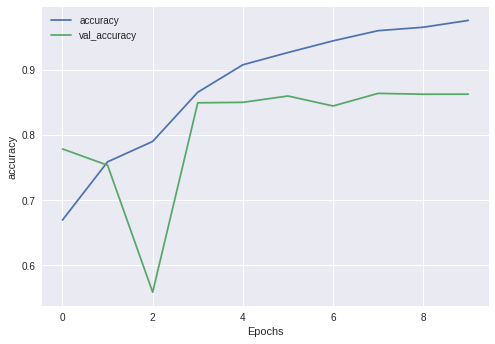

In [29]:
plot_graphs(history, 'accuracy')

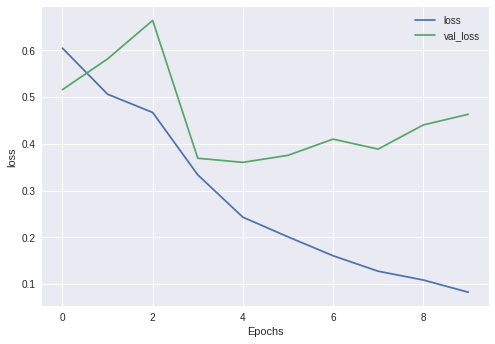

In [30]:
plot_graphs(history, 'loss')